In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import h5py
from pathlib import Path
from torch.utils import data
import logging
from datetime import datetime
from collections import Counter
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
import pandas as pd
import random

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(2)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
# Hyper-parameters 
num_classes = 4
input_size = 2000
sequence_length = 10
hidden_size = 64
num_layers = 1
learning_rate = 0.001
epochs = 100

In [5]:
# Wrapping the dataset with load function
class CustomDataset(data.Dataset):
    def __init__(self, file_path, transform=None):
        super().__init__()
        self.train_data_cache = []
        self.test_data_cache = []
        self.manual_data_cache = []
        self.full_test_data_cache = []
        self.validation_data_cache = []
        self.transform = transform
        self.label_count = [0, 0, 0]
        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('normalize*.h5')
        logging.debug(files)
        for h5dataset_fp in files:
            logging.debug(h5dataset_fp)
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    k = 0
                    j = 0
                    l = 0
                    print(gname)
                    if gname == 'neg_grenzflaeche':
                        label = 0
                    elif gname == 'neg_spitze':
                        label = 1
                    elif gname == 'pos_grenzflaeche':
                        label = 2
                    elif gname == 'pos_spitze':
                        label = 3

                    logging.debug(group.items())
                    for dname, ds in tqdm(group.items()):
                        if k < 1801: #3000
                            self.train_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            k += 1
                        elif j < 601: # 400
                            self.test_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                            j += 1
                        elif l < 601:
                            self.validation_data_cache.append([label, torch.tensor(ds[:20000]).unsqueeze(0).type(torch.float32)])
                        if k == 1801 and j == 601 and l == 601:
                            break
                                
    def __getitem__(self, index):
        return self.data_cache[index]

    def get_test_data(self):
        return self.test_data_cache

    def get_train_data(self):
        return self.train_data_cache
    
    def get_validation_data(self):
        return self.validation_data_cache

    def __len__(self):
        return len(self.data_cache)

In [6]:
customData = CustomDataset("/home/marcus/Dokumente/entladung/")

neg_grenzflaeche


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:01<00:00, 2514.63it/s]


neg_spitze


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 2493.95it/s]


pos_grenzflaeche


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:01<00:00, 2450.91it/s]


pos_spitze


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2480.73it/s]


In [7]:
# defining train and test sets
train_data = customData.get_train_data()
test_data = customData.get_test_data()
validation_data = customData.get_validation_data()
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [8]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        #out, _ = self.rnn(x, h0)  
        # or:
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

In [9]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [10]:
# the train loop
def train(dataloader, optimizer, criterion, model):
    model.train()
    running_loss = 0.0
    j = 0
    loss_values = []
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [labels, inputs]

        inputs = data[1]
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = data[0]
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

        # log statistics
        running_loss += loss.item()
        if i % 500 == 499:
            print(f"[{epoch}]Loss: {running_loss / 500} ")
        
    print(f"[{epoch}] Train Loss: {running_loss / (i+1)} ") 
    return running_loss / (i+1)

In [11]:
# testing the accuracy on single 1024 snippets
def split_test(dataloader,criterion, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    ACC = []
    true = []
    pred = []
    right_pred = []
    wrong_pred = []
    loss_values = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.reshape(-1, sequence_length, input_size).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            loss_values.append(loss.item())
            ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            for i, output in enumerate(outputs):
                if output.argmax(0) != labels[i]:
                    wrong_pred.append([inputs[i], labels[i], output])
                elif output.argmax(0) == labels[i]:
                    right_pred.append([inputs[i], labels[i], output])
    test_loss /= num_batches
    correct /= size
    print(f" Random Teilstück Error: Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true'), wrong_pred, right_pred, test_loss



In [12]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

529156


[0] Train Loss: 0.8452944673340896 
 Random Teilstück Error: Accuracy: 68.8%, Avg loss: 0.613177
[1] Train Loss: 0.5203893821814964 
 Random Teilstück Error: Accuracy: 72.6%, Avg loss: 0.481485
[2] Train Loss: 0.4305577391180499 
 Random Teilstück Error: Accuracy: 73.3%, Avg loss: 0.434259
[3] Train Loss: 0.3888035447433077 
 Random Teilstück Error: Accuracy: 74.9%, Avg loss: 0.406279
[4] Train Loss: 0.3665678346979207 
 Random Teilstück Error: Accuracy: 75.3%, Avg loss: 0.394438
[5] Train Loss: 0.3574751338054394 
 Random Teilstück Error: Accuracy: 79.0%, Avg loss: 0.381267
[6] Train Loss: 0.3479291693917636 
 Random Teilstück Error: Accuracy: 87.3%, Avg loss: 0.370622
[7] Train Loss: 0.3405260618390708 
 Random Teilstück Error: Accuracy: 75.5%, Avg loss: 0.365632
[8] Train Loss: 0.3332118258394044 
 Random Teilstück Error: Accuracy: 81.5%, Avg loss: 0.352338
[9] Train Loss: 0.3247289513719493 
 Random Teilstück Error: Accuracy: 85.4%, Avg loss: 0.347600
[10] Train Loss: 0.31280507815

 Random Teilstück Error: Accuracy: 98.2%, Avg loss: 0.068358
[84] Train Loss: 0.04774201972859687 
 Random Teilstück Error: Accuracy: 95.8%, Avg loss: 0.119773
[85] Train Loss: 0.06385409722811189 
 Random Teilstück Error: Accuracy: 97.7%, Avg loss: 0.061326
[86] Train Loss: 0.022345620624977965 
 Random Teilstück Error: Accuracy: 98.6%, Avg loss: 0.055908
[87] Train Loss: 0.027476144665531044 
 Random Teilstück Error: Accuracy: 96.7%, Avg loss: 0.086873
[88] Train Loss: 0.028526564835217493 
 Random Teilstück Error: Accuracy: 97.6%, Avg loss: 0.093432
[89] Train Loss: 0.0255540421168352 
 Random Teilstück Error: Accuracy: 98.3%, Avg loss: 0.053229
[90] Train Loss: 0.028346842058516782 
 Random Teilstück Error: Accuracy: 98.3%, Avg loss: 0.062938
[91] Train Loss: 0.039818654511252355 
 Random Teilstück Error: Accuracy: 97.5%, Avg loss: 0.096910
[92] Train Loss: 0.03873277909989501 
 Random Teilstück Error: Accuracy: 97.8%, Avg loss: 0.065628
[93] Train Loss: 0.028140960357569415 
 Rand

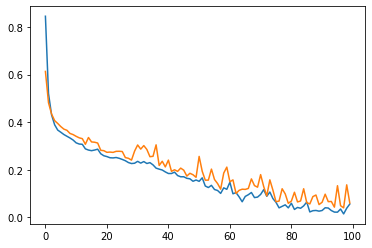

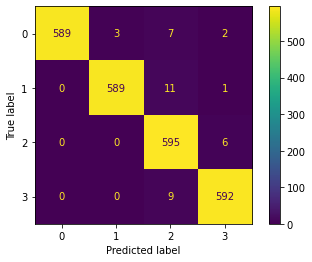

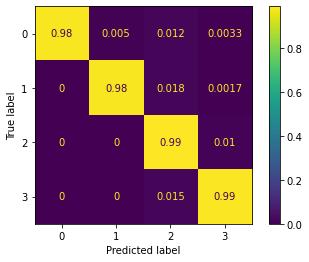

In [13]:
# training loop
train_loss = []
test_loss = []
for epoch in range(epochs):  # loop over the dataset multiple times
    train_loss += [train(train_dataloader, optimizer, criterion, model)]
    CM=split_test(test_dataloader, criterion, model)
    test_loss += [CM[4]]
print('Finished Training')

plt.plot(train_loss)
plt.plot(test_loss)
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=CM[0],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=CM[1],display_labels=[0, 1, 2, 3])
disp.plot()
plt.show()

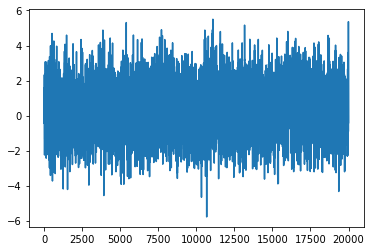

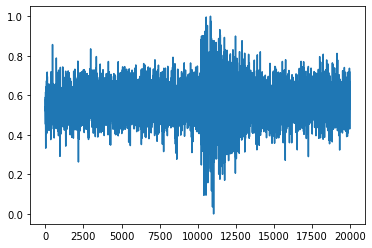

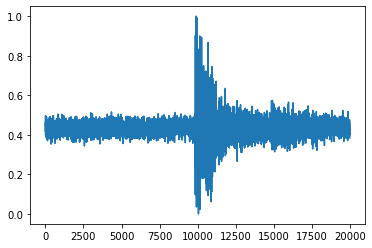

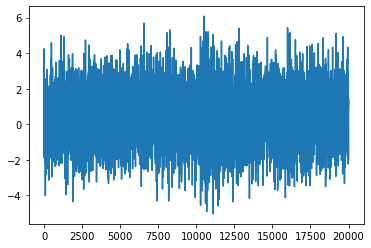

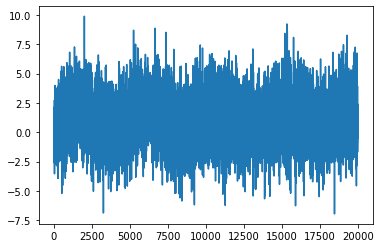

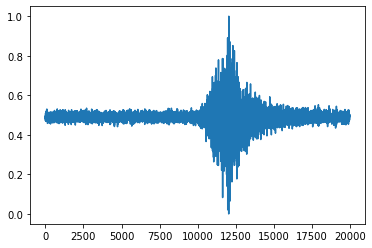

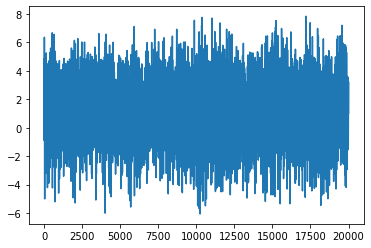

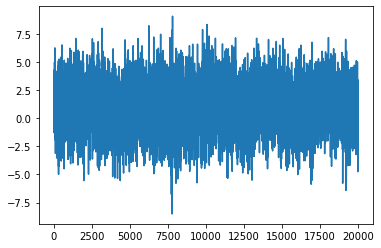

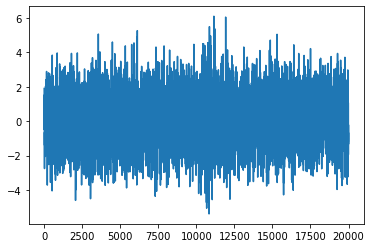

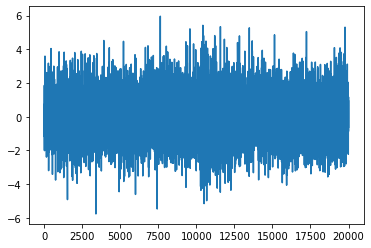

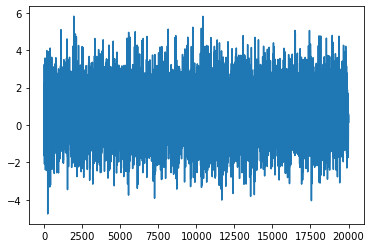

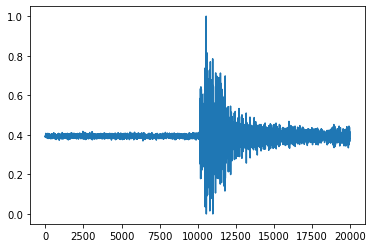

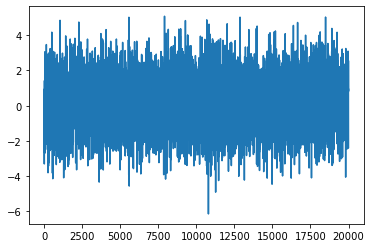

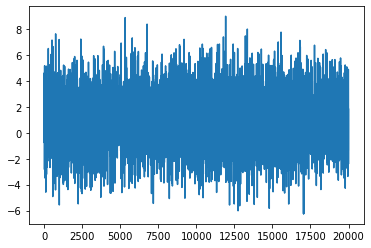

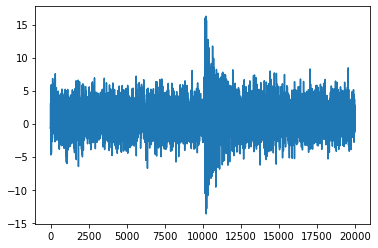

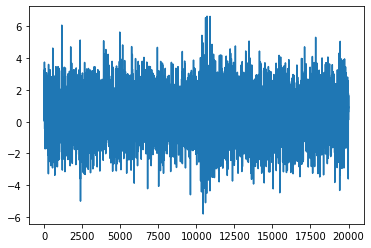

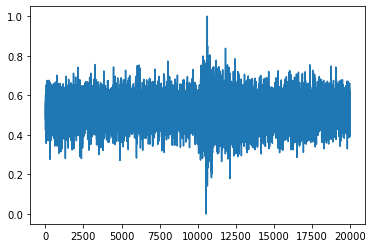

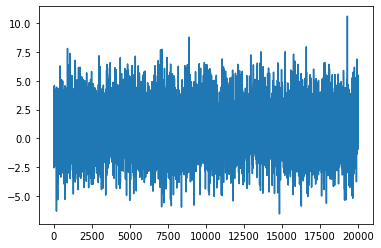

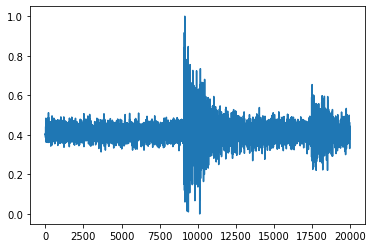

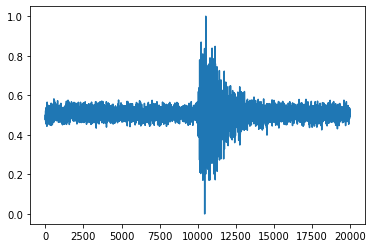

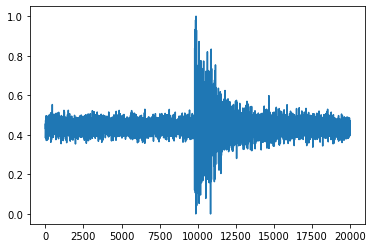

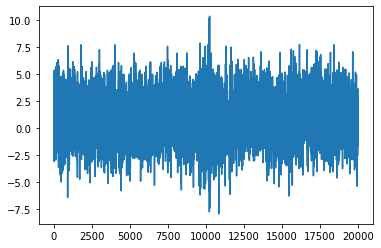

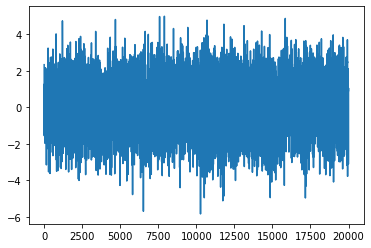

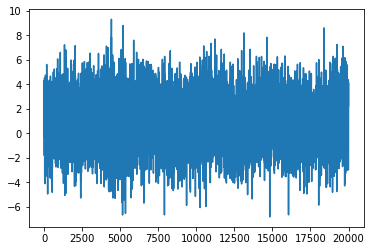

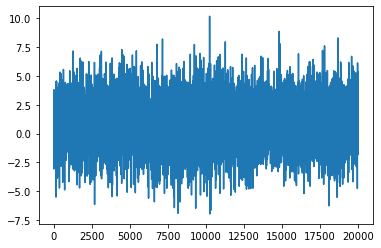

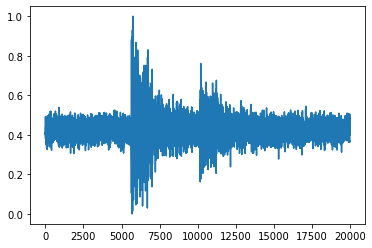

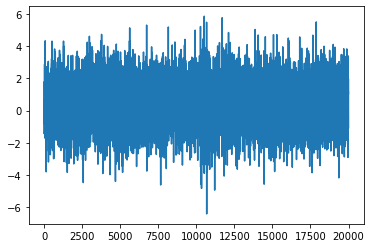

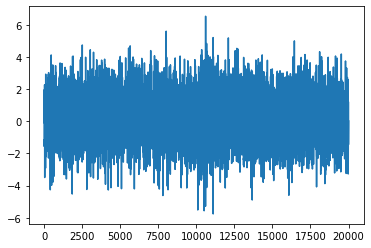

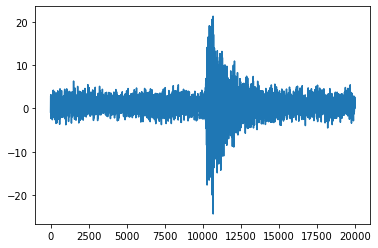

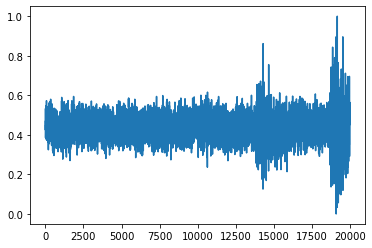

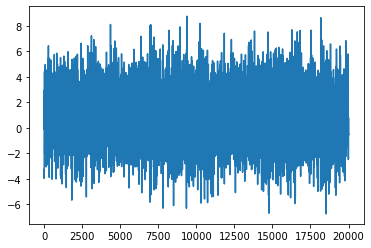

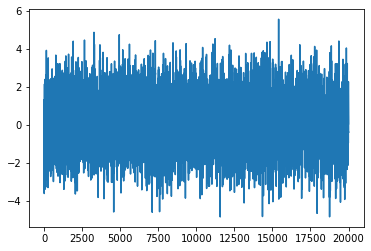

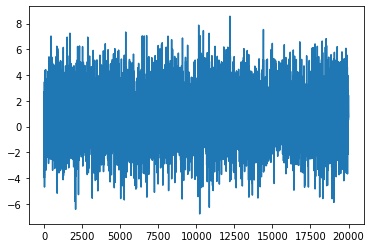

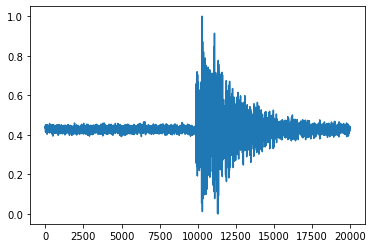

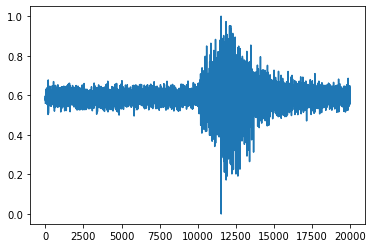

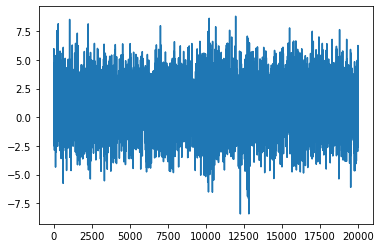

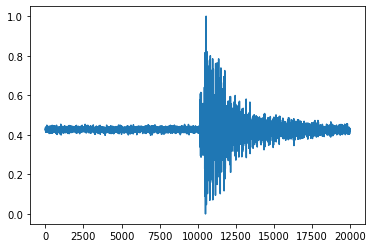

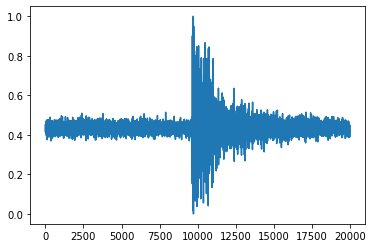

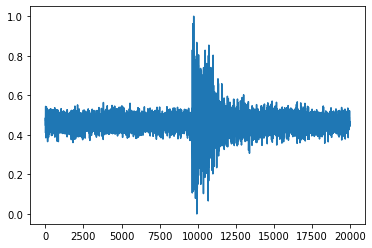

In [14]:
for i in CM[2]:    
    plt.plot(torch.flatten(i[0]).cpu())
    plt.show()


In [17]:
def validation(dataloader):
    acc = []
    pred = []
    true = []
    model.eval()
    wrong_pred = []
    right_pred = []
    validation_loss = 0
    correct = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    print(f"{size} {num_batches}")
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.reshape(-1, sequence_length, input_size).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            acc.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            for i, output in enumerate(outputs):
                if output.argmax(0) != labels[i]:
                    wrong_pred.append([inputs[i], labels[i], output])
                elif output.argmax(0) == labels[i]:
                    right_pred.append([inputs[i], labels[i], output])
    validation_loss /= num_batches
    correct /= size
    return correct, validation_loss

In [18]:
validation(validation_dataloader)

4392 69


(0.98816029143898, 0.047480105047883546)